In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
from scipy.stats import gmean

In [126]:
# constants
ticker = 'MSFT, TSLA, NVDA, GME, BB, CAT, T, JPM, COST, WMT, NKE, GM, F, MMM, EA, CMG, HD, BA, LMT, AXP'
start = '2014-01-01'
end = '2023-12-31'
mu_f = 0.042

In [127]:
# Get the data
market = yf.download('^GSPC', start=start, end=end).dropna()
stocks = yf.download(ticker, start=start, end=end).dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  20 of 20 completed


In [128]:
for stock in stocks['Adj Close']:
    print(f'{stock}: {stocks["Adj Close"][stock].shape[0]}')

print(f'Market: {market["Adj Close"].shape[0]}')

AXP: 2516
BA: 2516
BB: 2516
CAT: 2516
CMG: 2516
COST: 2516
EA: 2516
F: 2516
GM: 2516
GME: 2516
HD: 2516
JPM: 2516
LMT: 2516
MMM: 2516
MSFT: 2516
NKE: 2516
NVDA: 2516
T: 2516
TSLA: 2516
WMT: 2516
Market: 2516


In [129]:
# expected return based on historical average
def calculate_expected_return(data: pd.DataFrame) -> float:
    daily_returns = gmean(data['Adj Close'].pct_change().dropna() + 1) - 1
    return (daily_returns + 1) ** 252 - 1

In [130]:
mu_m = calculate_expected_return(market)
mu_i = calculate_expected_return(stocks)

# generate SML
beta = np.linspace(0, 2, 1000)
sml = mu_f + beta * (mu_m - mu_f)

# beta of stocks
daily_returns_market = market['Adj Close'].pct_change().dropna()
annual_var_market = np.var(daily_returns_market)*252

data = {}
for index, ticker in enumerate(stocks['Adj Close'].columns):
    try:
        annual_cov = np.cov(
            stocks['Adj Close'][ticker].pct_change().dropna(), 
            daily_returns_market
        )[0][1]*252
        data.setdefault(ticker, {})
        
        data[ticker]['beta_i'] = annual_cov / annual_var_market
        data[ticker]['mu_i'] = mu_i[index]
    except Exception as e:
        print(e)
        continue

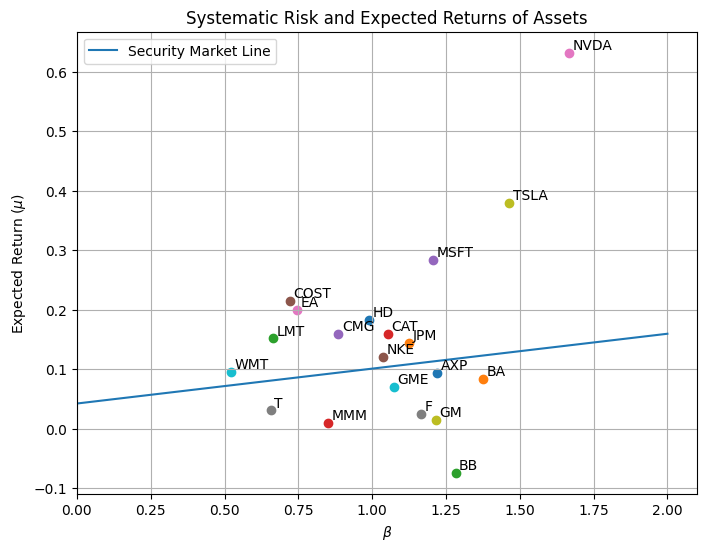

In [141]:
# plotting beta vs expected returns
plt.figure(figsize=(8, 6))
plt.plot(beta, sml, label='Security Market Line') # SML

for ticker, value in data.items():
    plt.scatter(value['beta_i'], value['mu_i'])
    plt.annotate(
        ticker, 
        xy=(value['beta_i'], value['mu_i']),
        xycoords='data',
        xytext=(2.5, 2.5),
        textcoords='offset points',
    )

plt.ylabel(rf'Expected Return ($\mu$)')
plt.xlabel(rf'$\beta$')
plt.title('Systematic Risk and Expected Returns of Assets')
plt.xlim(xmin=0)

plt.legend()
plt.grid()
plt.show()